In [2]:
import torch.multiprocessing as mp
mp.set_sharing_strategy("file_system")

In [7]:
import torch
from torch.utils.data import DataLoader
from datasets.cfg import num_classes, max_size
from models.models import build_model
from datasets.loader import DataModule, DataConfig
from datasets.base import collate_bb
from train.eval import Evaluator
from train.unsupervised_metrics import UnlabeledSanity
import mlflow.pytorch
device = torch.device("cuda")

model_B = build_model("maskrcnn_r50_fpn", num_classes).to(device)
model_B.load_state_dict(torch.load("./weights/maskrcnn_B_ep40.pth", map_location="cuda"))

model_uri = "file:///media/sdb1/mlflow/753485487056022103/2e19afb3d8e34c7fa8b50505a7dd259e/artifacts/model"
model_AB_Att = mlflow.pytorch.load_model(model_uri)



/tmp/ipykernel_1407717/3241898058.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_B.load_state_dict(torch.load("./weights/maskrcnn_B_ep40.pth", map_location="cuda

In [9]:
data = DataModule(DataConfig())
loader_B_test = data.make_loader_b_test()
loader_A_val  = data.make_loader_a_val()
loader_D_test  = data.make_loader_d_test()

In [4]:
e = Evaluator(device)
mb_B  = e.metrics_masks(model_B,  loader_B_test, num_classes=num_classes - 1)
mb_AB_Att = e.metrics_masks(model_AB_Att, loader_B_test, num_classes=num_classes - 1)

rows = [
    ["setup", "mAP50", "PQ_all", "mPQ", "AJI"],
    ["Model B", f"{mb_B['mAP50']:.3f}",  f"{mb_B['PQ_all']:.3f}",  f"{mb_B['mPQ']:.3f}",  f"{mb_B['AJI']:.3f}"],
    ["Model AttFPN A+B",   f"{mb_AB_Att['mAP50']:.3f}", f"{mb_AB_Att['PQ_all']:.3f}", f"{mb_AB_Att['mPQ']:.3f}", f"{mb_AB_Att['AJI']:.3f}"],
]
print("\n=== B-test metrics ===")
e.print_table(rows)


=== B-test metrics ===
setup             mAP50  PQ_all  mPQ    AJI  
Model B           0.885  0.582   0.581  0.504
Model AttFPN A+B  0.832  0.503   0.508  0.419


In [5]:
map50_D = e.map50(model_B, loader_D_test)
print(f"\nD test mAP50 (boxes, B model): {map50_D:.3f}")

map50_D = e.map50(model_AB_Att, loader_D_test)
print(f"\nD test mAP50 (boxes, Attention model): {map50_D:.3f}")


D test mAP50 (boxes, B model): 0.237

D test mAP50 (boxes, Attention model): 0.076


In [16]:
sanity = UnlabeledSanity(num_classes=24)

san_scores_b_b = e.sanity(model_B, loader_B_test, sanity)
san_scored_att_b = e.sanity(model_AB_Att, loader_B_test, sanity)

san_scores_b_d = e.sanity(model_B, loader_D_test, sanity)
san_scored_att_d = e.sanity(model_AB_Att, loader_D_test, sanity)

In [17]:
ds = san_scores_b_b["dataset_scores"]

print("\n=== Unlabeled B-test sanity (B model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

ds = san_scored_att_b["dataset_scores"]
print("\n=== Unlabeled B-test sanity (Attention model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

ds = san_scores_b_d["dataset_scores"]
print("\n=== Unlabeled D-test sanity (B model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

ds = san_scored_att_d["dataset_scores"]
print("\n=== Unlabeled D-test sanity (Attention model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")


=== Unlabeled B-test sanity (B model) ===
total: 0.483 count: 0.284 balance: 0.423 sex: 0.284 size: 0.940

=== Unlabeled B-test sanity (Attention model) ===
total: 0.412 count: 0.113 balance: 0.317 sex: 0.272 size: 0.946

=== Unlabeled D-test sanity (B model) ===
total: 0.311 count: 0.001 balance: 0.286 sex: 0.078 size: 0.878

=== Unlabeled D-test sanity (Attention model) ===
total: 0.383 count: 0.023 balance: 0.283 sex: 0.289 size: 0.936



Examples: D-test, B model


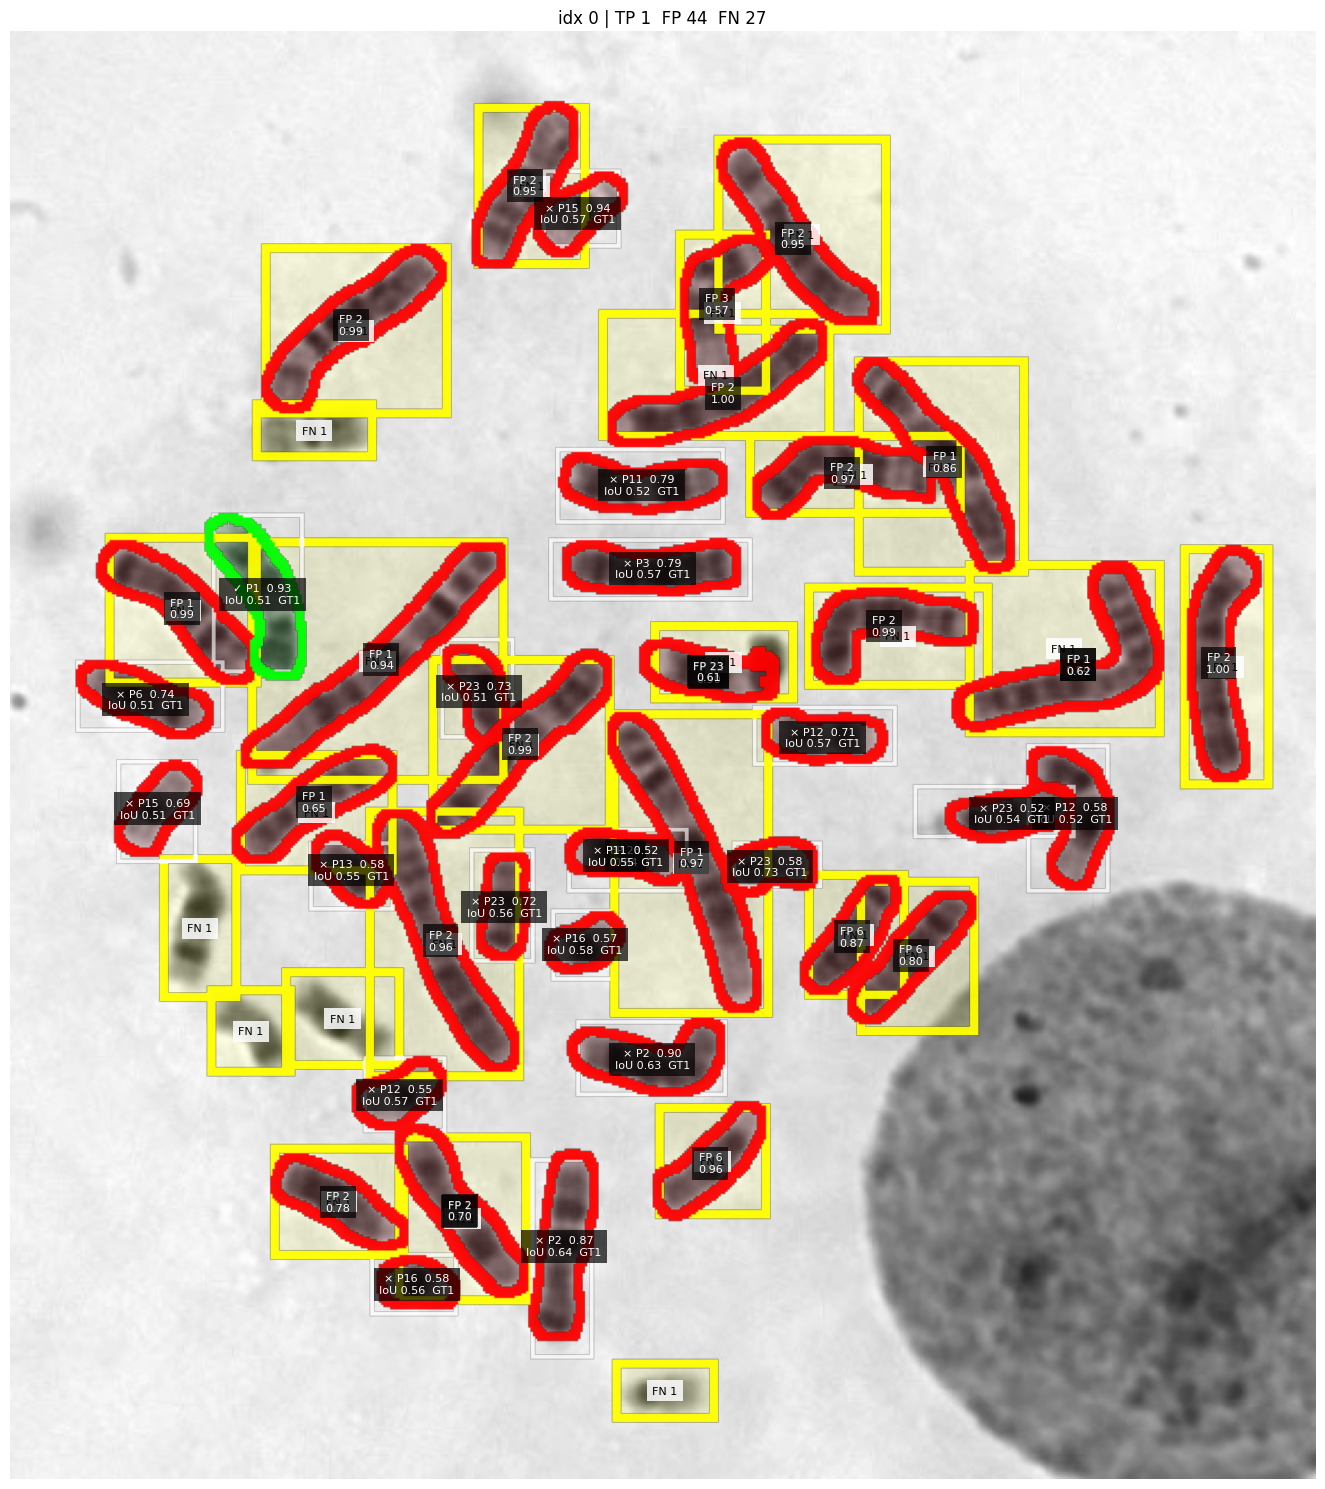


Examples: D-test, Att model


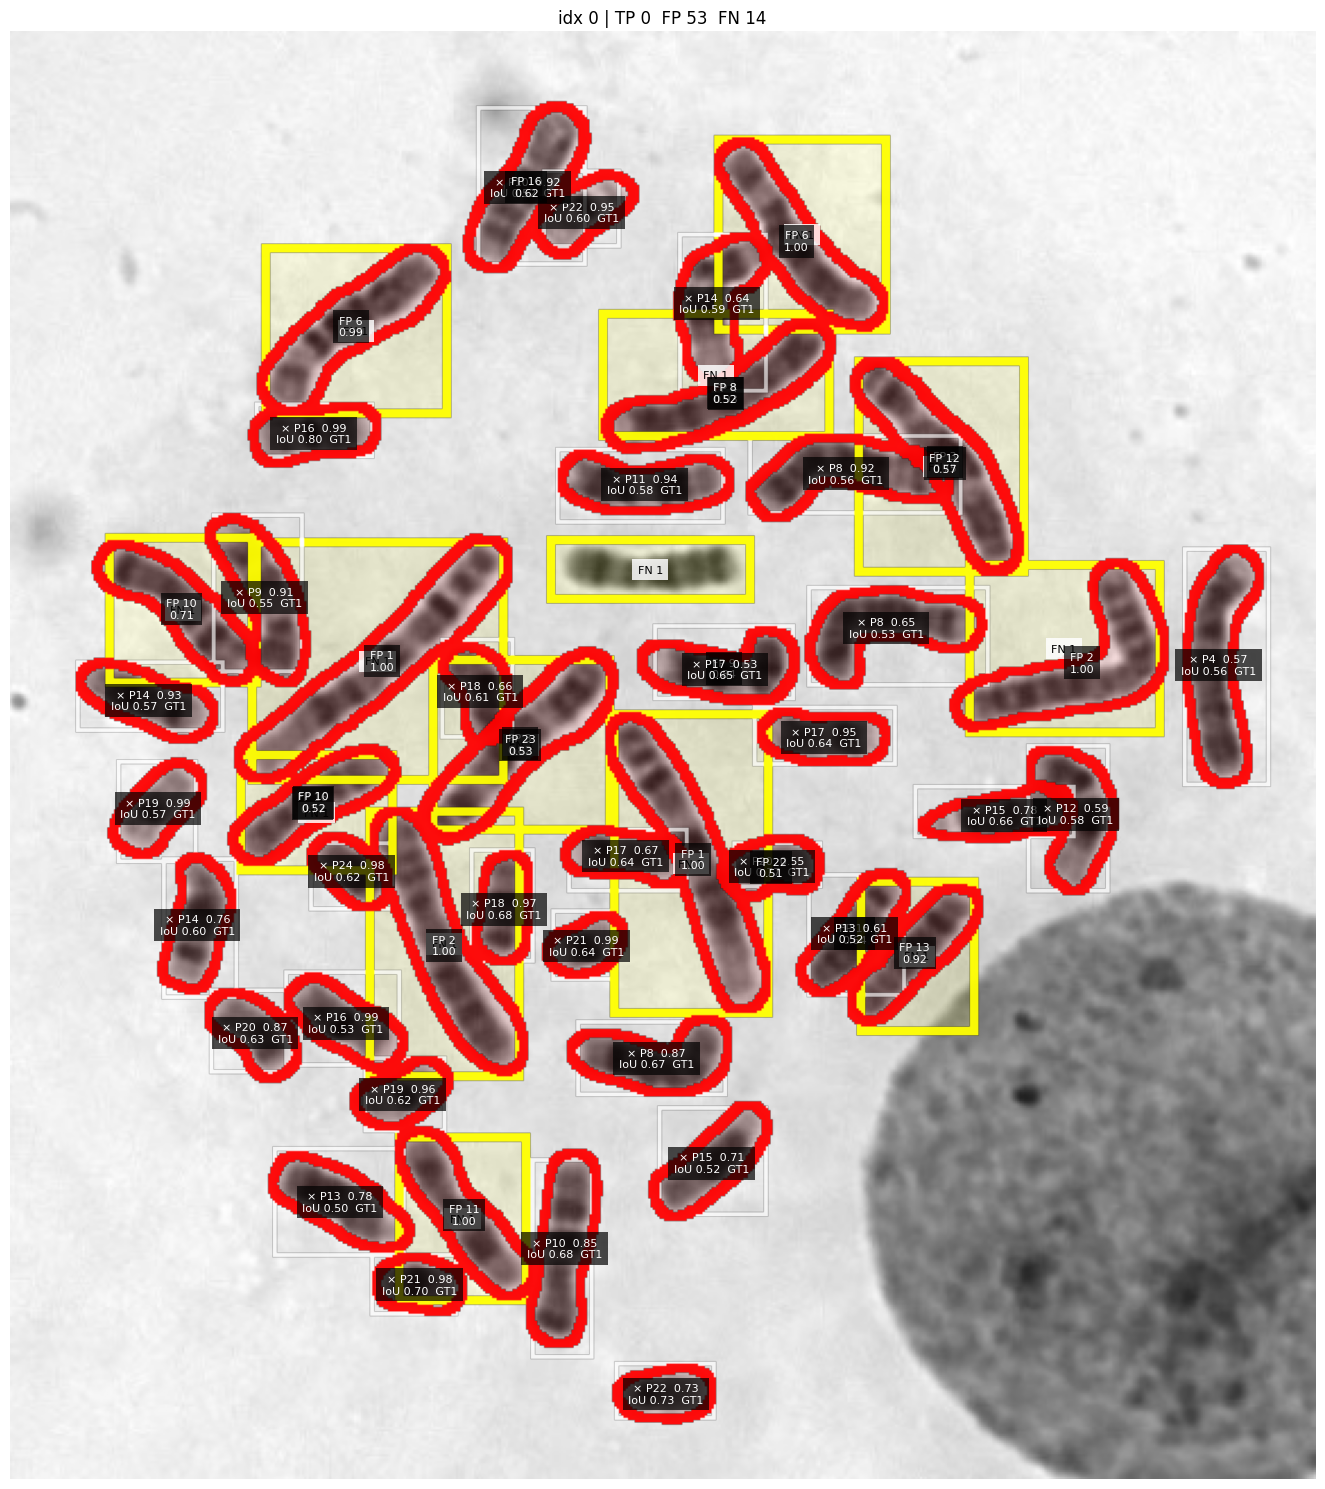

In [18]:
e.show_examples(data.ds_d_test, model_B,  n=1, score_thresh=0.5, title="D-test, B model")
e.show_examples(data.ds_d_test, model_AB_Att, n=1, score_thresh=0.5, title="D-test, Att model")

In [1]:

from train.karyo_plotting4 import plot_karyogram_from_output

def plot_karyogram_from_dataset(dataset, model, idx=0, score_thresh=0.5, pad=5):
    model.eval()
    img_t, target = dataset[idx]
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    plot_karyogram_from_output(img_t.cpu(), out, target, idx=idx, score_thresh=score_thresh, pad=pad)

plot_karyogram_from_dataset(data.ds_b_test, model_AB_Att, idx= 1)

/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


NameError: name 'data' is not defined

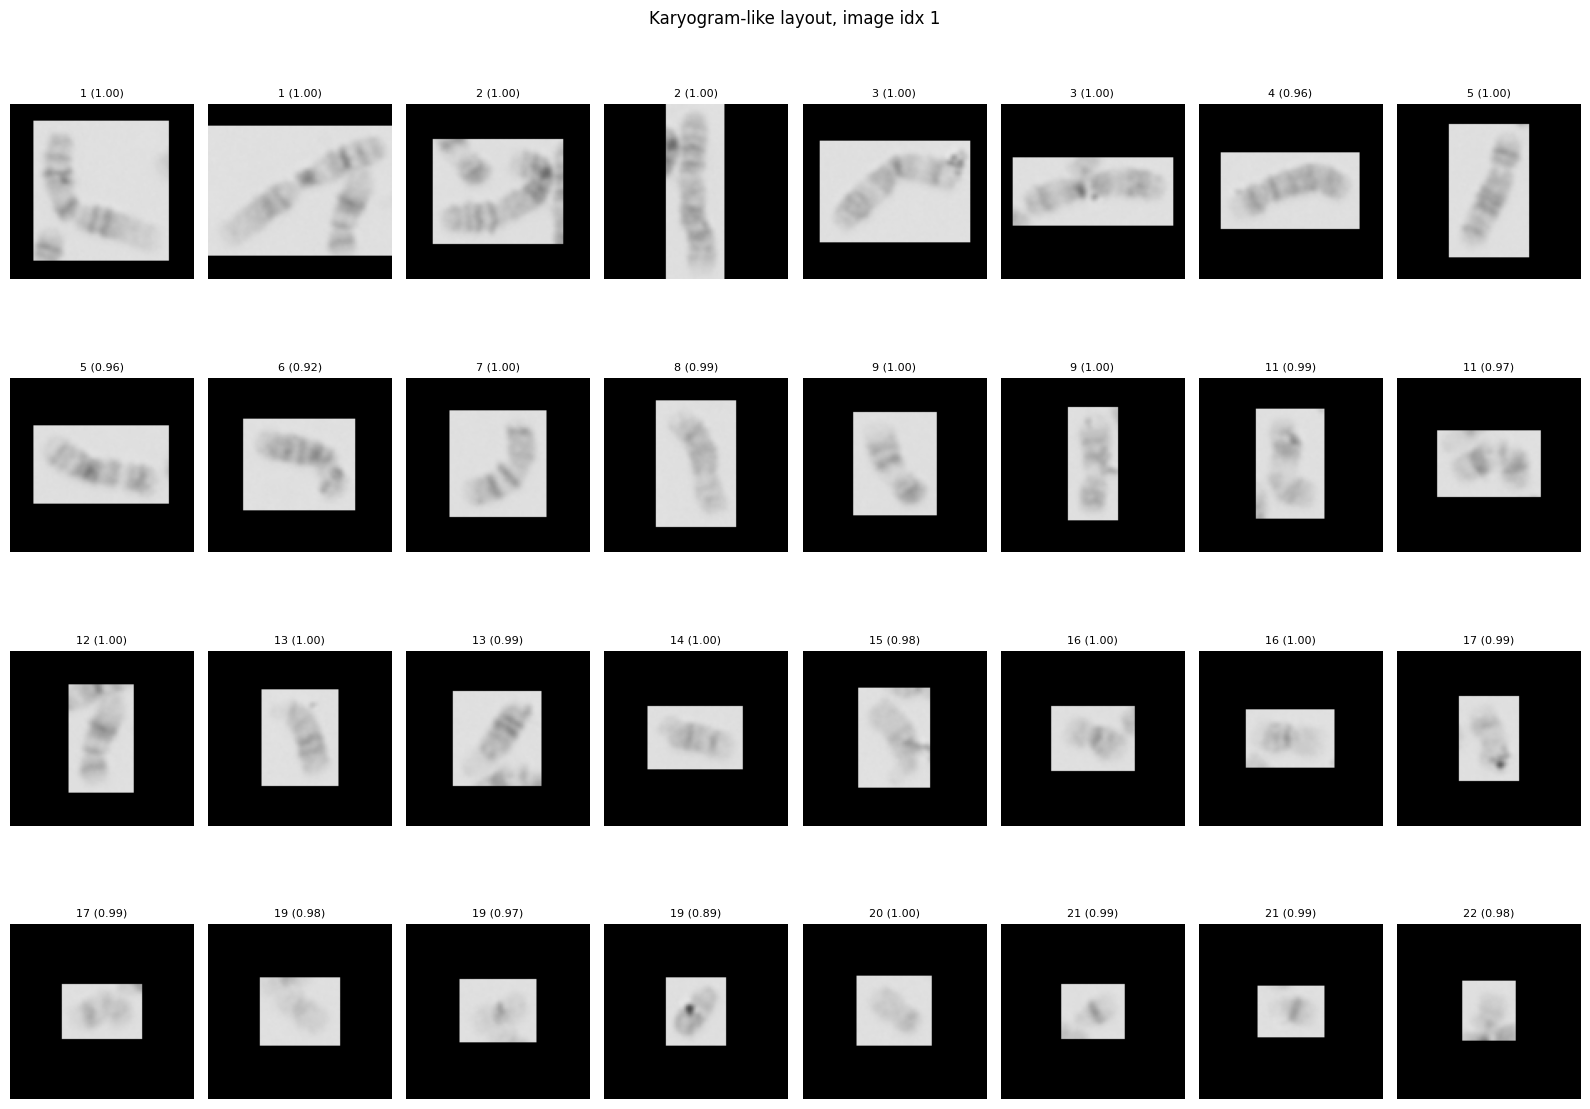

In [15]:
from train.karyo_plotting2 import plot_karyogram_from_output

def plot_karyogram_from_dataset(dataset, model, idx=0, score_thresh=0.5,pad=5,cols=8):
    model.eval()
    img_t, _ = dataset[idx]
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    plot_karyogram_from_output(img_t.cpu(), out, idx, score_thresh, pad, cols)

plot_karyogram_from_dataset(data.ds_b_test, model_AB, idx= 1)